In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.decomposition import PCA

from sklearn.feature_selection import VarianceThreshold, SelectFromModel, RFECV, SequentialFeatureSelector

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import accuracy_score

from sklearn.datasets import make_classification, load_wine, load_breast_cancer, load_diabetes, load_digits

In [2]:
plt.style.use('seaborn-darkgrid')

In [3]:
def plot_scatter(x, y, auto_scaled=True, title=None, clusters=None):
    plt.figure(figsize=(4, 4))
    plt.scatter(x, y, c=clusters, cmap='bwr')
    
    if not auto_scaled:
        plt.axis('square')
    
    plt.grid(True)
    plt.title(title)
    
    plt.show()
    
def return_X_y(data, target_column):
    return data.drop(target_column, axis=1), data[target_column]

In [4]:
wine_sklearn = load_wine(as_frame=True)
wine_data, wine_labels = wine_sklearn['data'], wine_sklearn['target']

# Homework

## Exercise  1 - Scaling (2 points)

Perform standardization for wine dataset (`wine_data`) using only basic python, numpy and pandas (without using `StandardScaler` and sklearn at all). Implementation of function (or class) that can get dataset as input and return standardized dataset as output is preferrable, but not necessary.

Compare you results (output) with `StandardScaler`.

**NOTE:**

- 1 point for functional version, 2 points for implementing scaling as sklearn pipeline compartible class. 
- Maximum for the exercise is 2 points.


### Simple version (1 point)

In [5]:
# 1 point
def scale(X):
    return (X - X.mean()) / X.std(ddof=0)

In [6]:
assert np.allclose(np.array(scale(wine_data)), StandardScaler().fit_transform(wine_data))

### Pipeline Version (2 points)

In [7]:
# 2 points
from sklearn.base import BaseEstimator, TransformerMixin
class CustomScaler(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, copy=True, with_mean=True, with_std=True):
        # your code here
        self.copy = copy
        self.with_mean = with_mean
        self.with_std = with_std

    def fit(self, X, y=None):
        self.mean_ = None
        if self.with_mean:
            self.mean_ = X.mean().values

        self.var_ = None
        if self.with_std:
            self.var_ = X.var(ddof=0).values

        self.scale_ = None
        if self.with_std:
            std = np.sqrt(self.var_)
            self.scale_ = np.where(std==0, 1, std) 

        return self

    def transform(self, X, y=None, copy=None):
        if copy:
            X_copy = X.copy()
            if np.all(self.mean_) == None and np.all(self.scale_) == None:
                return X_copy
            if np.all(self.mean_) == None:
                return X_copy / self.scale_
            if np.all(self.scale_) == None:
                return X_copy - self.mean_
            return (X_copy - self.mean_) / self.scale_
        else:
            if np.all(self.mean_) == None and np.all(self.scale_) == None:
                return X
            if np.all(self.mean_) == None:
                return X / self.scale_
            if np.all(self.scale_) == None:
                return X - self.mean_
            return (X - self.mean_) / self.scale_

In [8]:
assert np.allclose(CustomScaler().fit_transform(wine_data), StandardScaler().fit_transform(wine_data))

## Exercise  2 - Visualization (3 points)

As noted earlier, standardization/normalization of data can be crucial for some distance-based ML methods.

Let’s generate some toy example of unnormalized data and visualize the importance of this process once more:

In [9]:
feature_0 = np.random.randn(1000) * 10   
feature_1 = np.concatenate([np.random.randn(500), np.random.randn(500) + 5])
data = np.column_stack([feature_0, feature_1])
data 

array([[-15.92349977,  -0.52330833],
       [ 10.6047725 ,   0.04030163],
       [  9.14423338,  -0.46808241],
       ...,
       [  1.07707102,   3.67228735],
       [-17.56153189,   4.94315135],
       [-14.79899799,   5.13725963]])

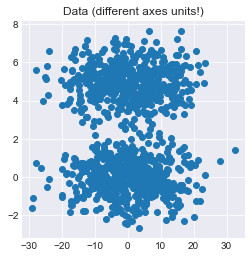

In [10]:
plot_scatter(data[:, 0], data[:, 1], auto_scaled=True, title='Data (different axes units!)')

**NOTE:** on the plot above axes are scaled differently and we can clearly see two potential *classes/clusters*. In fact `matplotlib` performed `autoscaling` (which is basically can be considered as `MinMaxScaling` of original data) just for better visualization purposes.

Let's turn this feature off and visualize the original data on the plot with equally scaled axes:

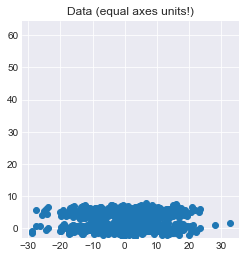

In [11]:
plot_scatter(data[:, 0], data[:, 1], auto_scaled=False , title='Data (equal axes units!)')

This picture is clearly less interpretable, but much closer to "how distance-based algorithm see the original data": separability of data is hardly noticable only because the variation (std) of x-feature is much bigger in absolute numbers.

Perform `StandardScaling` and `MinMaxScaling` of original data; visualize results for each case (**use `plot_scatter` with `auto_scaled=False`**):

### MinMaxScaling (0.5 point)

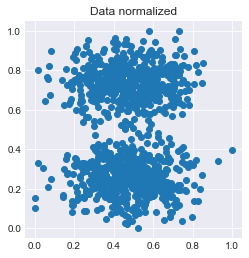

In [12]:
## your code
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)
plot_scatter(data_scaled[:, 0], data_scaled[:, 1], auto_scaled=False , title='Data normalized')

### StandardScaler (0.5 point)

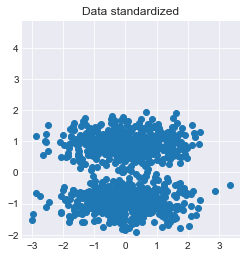

In [13]:
## your code
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
plot_scatter(data_scaled[:, 0], data_scaled[:, 1], auto_scaled=False , title='Data standardized')

We see that with preliminary scaling pictures are much more interpretable and clusters of data are well separable.

### (Bonus) K-means (2 points)

Illustrate the impact of scaling on basic distance-based clustering algorithm [K-means](https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1) using `data` generated above.

**NOTE:** basically, you don't need understanding K-means algorithm here, you just need to:

1) run algorithm (with k=2, k - number of clusters/classes) on unscaled data    
2) run algorithm (with k=2) on scaled data    
3) plot results: highlight different clusters using different colors.

You can use this [question](https://stats.stackexchange.com/questions/89809/is-it-important-to-scale-data-before-clustering/89813) as a hint, but I recommend you to plot results using `plot_scatter` with `equal_scaled=True`: it might help you to intuitively understand the reasons of such scaling impact.


In [14]:
from sklearn.cluster import KMeans

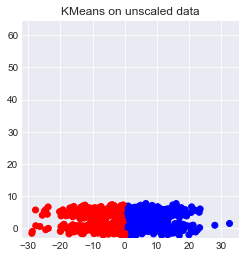

In [15]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(data)
plot_scatter(data[:, 0], data[:, 1], auto_scaled=False , title='KMeans on unscaled data', clusters=kmeans.labels_)

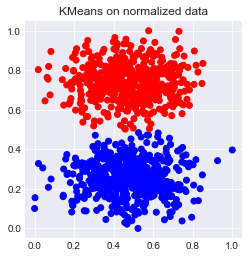

In [16]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)
kmeans.fit(data_scaled)
plot_scatter(data_scaled[:, 0], data_scaled[:, 1], auto_scaled=False , title='KMeans on normalized data', clusters=kmeans.labels_)

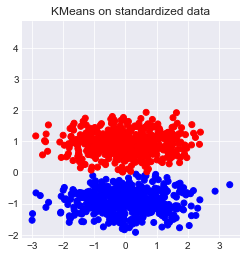

In [17]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
kmeans.fit(data_scaled)
plot_scatter(data_scaled[:, 0], data_scaled[:, 1], auto_scaled=False , title='KMeans on standardized data', clusters=kmeans.labels_)

KMeans don't see "right" clusters when data is unscaled (because range of first "non-clustered" feature is much more bigger in absolute numbers) and performs very well when data is scaled.

## Exercise  3 - Preprocessing Pipeline (2 points)

In [18]:
wine_train, wine_val, wine_labels_train, wine_labels_val = train_test_split(wine_data, wine_labels, 
                                                                            test_size=0.3, random_state=42)

Train model (for example, `LogisticRegression(solver='liblinear', penalty='l1')` on raw `wine_train` data; then train same model after data scaling; then add feature selection (and train model again on scaled data). For each experiment all required preprocessing steps (if any) should be wrapped into sklearn pipeline.

Measure `accuracy` of all 3 approaches on `wine_val` dataset. Describe and explain results.

In [19]:
# your code
def make_model(scale=False, select_features=False):
    logreg = LogisticRegression(solver='liblinear', penalty='l1') 
    
    if scale:
        return Pipeline([
            ('sca', StandardScaler()),
            ('logreg', logreg)
        ])
    if select_features:
        return Pipeline([
            ('sca', StandardScaler()),
            ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=42))),
            ('logreg', logreg)
        ])
    return Pipeline([
            ('logreg', logreg)
        ])

In [20]:
# raw data
logreg = make_model()
logreg.fit(wine_train, wine_labels_train)
y_pred = logreg.predict(wine_val)
lr_unscaled_acc = accuracy_score(y_true=wine_labels_val, y_pred=y_pred)

In [21]:
# scaled data
logreg = make_model(scale=True)
logreg.fit(wine_train, wine_labels_train)
y_pred = logreg.predict(wine_val)
lr_scaled_acc = accuracy_score(y_true=wine_labels_val, y_pred=y_pred)

In [22]:
# scaled data with future selection
logreg = make_model(select_features=True)
logreg.fit(wine_train, wine_labels_train)
y_pred = logreg.predict(wine_val)
lr_selected_acc = accuracy_score(y_true=wine_labels_val, y_pred=y_pred)
print(f'initial features: {wine_train.columns.to_list()}')
print(f'number of initial features: {len(wine_train.columns.to_list())}')
print(f'selected features: {logreg[:-1].get_feature_names_out()}')
print(f'number of selected features: {len(logreg[:-1].get_feature_names_out())}')

initial features: ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
number of initial features: 13
selected features: ['alcohol' 'flavanoids' 'color_intensity' 'hue'
 'od280/od315_of_diluted_wines' 'proline']
number of selected features: 6


In [23]:
pd.DataFrame([lr_unscaled_acc, lr_scaled_acc, lr_selected_acc], 
                index=['LogReg with L1 on raw data', 'LogReg with L1 on scaled data', 'LogReg with L1 on selected features'], 
                columns=['Accuracy'])

,Accuracy
LogReg with L1 on raw data,0.981481
LogReg with L1 on scaled data,0.981481
LogReg with L1 on selected features,1.000000


We don't see any difference in accuracies of models trained on unscaled and scaled data, but accuracy increased after model-based feature selection, which selected only 6 most important features and get rid of unimportant ones.  

Actually, I expected that preliminary scaling will affect accuracy of our model, because we saw in overfitting and regularization task why scaling is important  before fitting a regularized model (features that take values in small range and most important ones get bigger weights and regularization penalizes them while noisy and unimportant features remain unpenalized).  

Let's have a closer look to deviations of our features:

In [24]:
wine_data.std().sort_values()

nonflavanoid_phenols              0.124453
hue                               0.228572
ash                               0.274344
proanthocyanins                   0.572359
total_phenols                     0.625851
od280/od315_of_diluted_wines      0.709990
alcohol                           0.811827
flavanoids                        0.998859
malic_acid                        1.117146
color_intensity                   2.318286
alcalinity_of_ash                 3.339564
magnesium                        14.282484
proline                         314.907474
dtype: float64

We see that std of proline feature is almost 315, which much more bigger than std of other features. Scaling should be important in that case.  
To get a clearer sense of what happens let's use cross-validation instead of train-test-split:

In [25]:
print(f'Accuracy on unscaled data: {cross_val_score(make_model(), wine_data, wine_labels, scoring="accuracy").mean()}')
print(f'Accuracy on scaled data: {cross_val_score(make_model(scale=True), wine_data, wine_labels, scoring="accuracy").mean()}')
print(f'Accuracy on scaled data with selected features: {cross_val_score(make_model(select_features=True), wine_data, wine_labels, scoring="accuracy").mean()}')

Accuracy on unscaled data: 0.961111111111111
Accuracy on scaled data: 0.9833333333333332
Accuracy on scaled data with selected features: 0.9833333333333332


Now we see that scaling indeed improves our model performance.  
Feature selection doesn't give us any performance boost during cross-validation. I guess this is because our dataset is quite small (178x13) and doesn't contain completely useless features, but in the case when there are unnecessary features, feature selection can improve model performance.

## Exercise 4 - manual PCA (5 points)
The task is to solve PCA as an optimization problem, without explicitly doing eigen value decomposition.
In the most general setting PCA is minimization of reconstruction error of a projection of given rank $q$

$$\min_{\mu, \lambda_1,\ldots, \lambda_n, \mathbf{V}_q} \sum_{i=1}^n ||x_i - \mu - \mathbf{V}_q \lambda_i||^2$$

With a number of steps that can be found here https://stats.stackexchange.com/a/10260 this task transforms to
 $$\max_{u_i} \sum_{i=1}^q u_i^T \mathbf{S} u_i$$
 where $\mathbf{S}$ is the sample covariance matrix (after standartization) and $u_1, \ldots, u_q$ are the $q$ are orthonormal columns in $\mathbf{V}_q$.
 Let us solve this optimization problem with `scipy.optimize` library.
 
 Additional 2 point are given for visualization of the results.

### PCA (3 points)

In [26]:
wine_data, wine_labels = wine_sklearn['data'], wine_sklearn['target']

Find a covariance matrix of standartized data and assing it to S.

In [27]:
## your code
data_scaled = StandardScaler().fit_transform(wine_data)
number_of_observations = data_scaled.shape[0]
number_of_features = data_scaled.shape[1]
cov_matrix = np.zeros((number_of_features, number_of_features))
for i in range(number_of_features):
    for j in range(number_of_features):
        cov_matrix[i][j] = np.sum((data_scaled[:, i] - data_scaled[:, i].mean()) * (data_scaled[:, j] - data_scaled[:, j].mean())) / (number_of_observations - 1)
S = cov_matrix

If your code is correct, the following assert should be Ok.

In [28]:
assert np.allclose(np.linalg.norm(S), 5.787241159764733)

In [29]:
from scipy.optimize import minimize

def objective(x):
    # your code: write objective of the problem (don't forget that scipy does min while we need max)
    return - x.T @ S @ x

def norm_constraint(x):
    # your code: constaraint norm of x to be 1, function should return 0 if constraint holds
    return 1 - np.linalg.norm(x)

con1 = {'type': 'eq', 'fun': norm_constraint}

# your code: initial vector to start optimization
x0 = np.zeros((S.shape[0],))

sol = minimize(objective, 
               x0, 
               constraints = [con1]
              )
x0 = sol.x

Hurray! We have first vector! Let's do another one.

In [30]:
def orthogonality_constraint(x):
    # your code: x should be orthogonal to x0, function should return 0 if constraint holds
    return x.T @ x0

con2 = {'type': 'eq', 'fun': orthogonality_constraint}

# your code: initial vector to start optimization
x1 = np.zeros((S.shape[0],))

sol = minimize(objective, 
               x1, 
               constraints = [con1, con2]
              )

x1 = sol.x

If your solution is correct, the following asserts should be Ok.

In [31]:
assert np.allclose(x0@S@x0, 4.732436977583595)
assert np.allclose(x1@S@x1, 2.5110809296451233)

### Visualization (2 points)

Visualize the points after applying custom dimension reduction with 2 components.

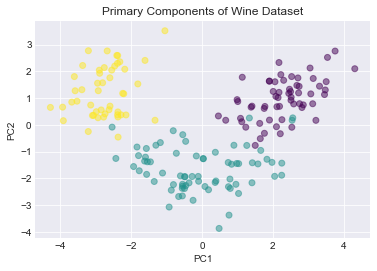

In [38]:
top_2_eigenvectors = np.vstack((x0, x1)).T
transformed_data = data_scaled @ top_2_eigenvectors
plt.scatter(transformed_data[:,0], transformed_data[:,1], c=wine_labels, cmap='viridis', alpha=0.5)
plt.title("Primary Components of Wine Dataset")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

## Exercise 5 - Boruta (3 points)

Let us classify handwritten digits 0, 1 and 2. 
To make task not so easy the images are binarized (no shadows of gray present) as it happens with xerocopied documents.

Let us also find out to which parts of an image there's no need to look in order to clasify three digits of interest.

In [33]:
X, y = load_digits(n_class=3, return_X_y=True, as_frame=True)
X = (X>10).astype(int)

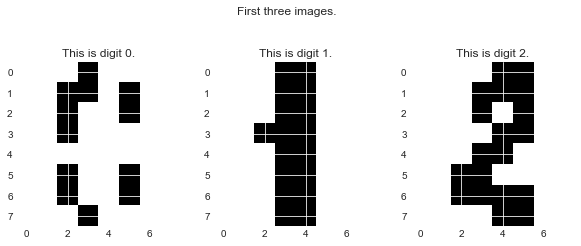

In [34]:
f, ax = plt.subplots(1,3,figsize=(10,4))
for i in range(3):
    ax[i].imshow(X.iloc[i].values.reshape(8,8))
    ax[i].set_title(f"This is digit {y[i]}.")
plt.suptitle("First three images.")
plt.show()

Split data into train and test, let test size be 30% of the dataset and fix random state to 42:

In [35]:
X_train, X_val, y_train, y_val = ## your code here

SyntaxError: invalid syntax (4179240895.py, line 1)

In [ ]:
assert y_val.shape[0] == 162
assert y_val.sum() == 169

Fit a RandomForestClassifier with max_depth=13 and evaluate it's performance:

In [ ]:
clf = RandomForestClassifier(max_depth=13)

# your code here

acc = # your code here
print(acc)

In [ ]:
assert acc > 0.98

Now we will use Boruta to find redundand pixels. If the package is not installed in your system, uncomment and run the following cell.

In [ ]:
# ! pip install boruta

In [ ]:
from boruta import BorutaPy

feat_selector = BorutaPy(RandomForestClassifier(max_depth=13), 
                         n_estimators='auto', 
                         verbose=0, 
                         max_iter=100,
                         random_state=42)

# your code here: do run the boruta

Let us print redundant pixels as a mask. Does the result looks similar to mine (or to Among us chracters)? 

In [ ]:
mask = np.array(feat_selector.support_).reshape(8,8)
plt.imshow(mask);

At the end let us redo  classification but only with selected features

In [ ]:
clf = RandomForestClassifier(max_depth=13)

# your code here

acc = # your code here
print(acc)

In [ ]:
assert acc > 0.99

# Materials & References

1. General article about feature engineering and selection (main reference):
https://github.com/Yorko/mlcourse.ai/blob/master/jupyter_english/topic06_features_regression/topic6_feature_engineering_feature_selection.ipynb

2. Feature engineering/preprocessing, using scikit-learn API (great code examples, but really brief explanation):    
https://scikit-learn.org/stable/modules/preprocessing

3. Feature scaling/normalization:     
https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35

4. Log Transform/power transform:    
https://medium.com/@kyawsawhtoon/log-transformation-purpose-and-interpretation-9444b4b049c9

6. Missing values preprocessing using scikit-learn API (great code examples, great explanation):    
https://scikit-learn.org/stable/modules/impute.html

7. Feature selection scikit-learn API (great code examples, great explanation):   
https://scikit-learn.org/stable/modules/feature_selection.html

8. Melbourne housing dataset source:    
https://www.kaggle.com/anthonypino/melbourne-housing-market